## Additional exercise #1  (CSE 628) 

In [7]:
import nltk
from nltk.corpus import gutenberg
from nltk import bigrams, trigrams
import string
from decimal import *
import numpy as np
import random
import re
from urllib import urlopen
import matplotlib.pyplot as plt
#Setting decimal point precision
getcontext().prec = 6

### Zipf's' law and Heap's law

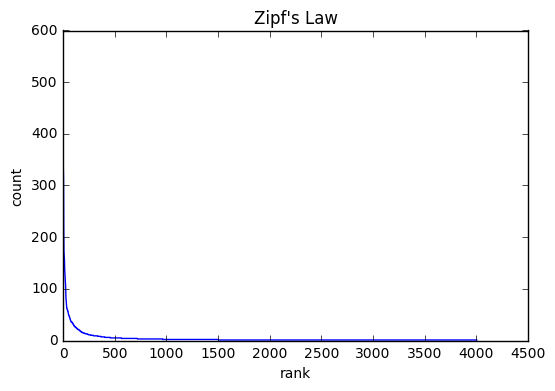

/home/lenaaaa/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log


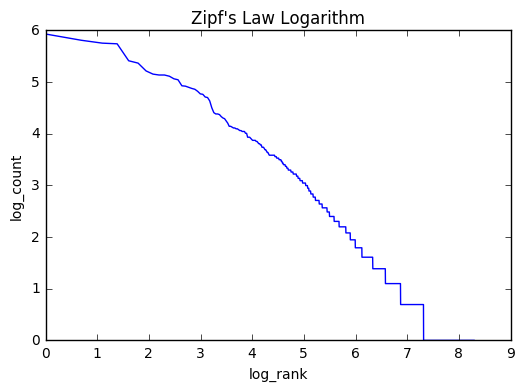

In [10]:
url = 'http://www.gutenberg.org/cache/epub/23434/pg23434.txt'
text = urlopen(url).read().decode('utf-8')

######## Zipf's law

punctuations = list(string.punctuation)
word_count = dict()
macbeth_sentences = gutenberg.sents('shakespeare-macbeth.txt')
for sent in macbeth_sentences:
    for token in sent:
        if token not in punctuations:
            if token in word_count:
                word_count[token] += 1
            else:
                word_count[token] = 1

sorted_wc = sorted(word_count.items(), key=lambda x: (-x[1], x[0]))

rank = list(range(0, len(word_count)))
count = [x[1] for x in sorted_wc]    

plt.plot(rank, count)
plt.xlabel('rank')
plt.ylabel('count')
plt.title("Zipf's Law")
plt.show()

plt.plot(np.log(rank), np.log(count))
plt.xlabel('log_rank')
plt.ylabel('log_count')
plt.title("Zipf's Law Logarithm")
plt.show()

In [62]:
#Importing data
new_data = []
data = gutenberg.sents('austen-sense.txt')
data = data[2:]

#Add sentence de-limiters, remove punctuations and switch to lower-case
for d in data:
    d = [''.join(c for c in s if c not in string.punctuation) for s in d]
    d = [s for s in d if s]
    d.insert(0,'<s>')
    d.append('</s>')
    d = [str(w.lower()) for w in d]
    new_data.append(d)
    
#The first 1000 sentences go into training set
train_set = new_data[0:1000]
#The second 1000 sentences go into test set
test_set = new_data[1000:2000]

train_words = [val for sublist in train_set for val in sublist]
test_words = [val for sublist in test_set for val in sublist]
num_words = len(train_words)

print "Size of training set: {} sentences and {} unique words".format(len(train_set), len(set(train_words)))
print "Size of test set: {} sentences and {} unqiue words".format(len(test_set), len(set([val for sublist in test_set for val in sublist])))

Size of training set: 1000 sentences and 2882 unique words
Size of test set: 1000 sentences and 2611 unqiue words


## 1. Training and evaluating N-gram models

In [144]:
#Calculating bigrams
train_bigrams = list(bigrams(train_words))
#Calculating trigrams
train_trigrams = list(trigrams(train_words))
condition_pairs = [((w0, w1), w2) for w0, w1, w2 in train_trigrams]

#Calculating frequency/conditional frequency for N-grams
uni_freq = nltk.FreqDist(train_words)
bi_cfreq = nltk.ConditionalFreqDist(train_bigrams)
tri_cfreq = nltk.ConditionalFreqDist(condition_pairs)

#Calculating frequency/conditional probability for N-grams
uni_prob = {}
for k,v in uni_freq.iteritems():
    uni_prob[k] = Decimal(v)/Decimal(num_words)
    
bi_prob = nltk.ConditionalProbDist(bi_cfreq, nltk.MLEProbDist)
tri_prob = nltk.ConditionalProbDist(tri_cfreq, nltk.MLEProbDist)

print "Number of unigrams: {}".format(len(set(train_words)))
print "Number of bigrams: {}".format(len(set(train_bigrams)))
print "Number of trigrams: {}".format(len(set(train_trigrams)))

Number of unigrams: 2882
Number of bigrams: 14341
Number of trigrams: 21306


### Observation
We can observe that the number of unqiue N-grams increases on increasing the value of N. This is because, eg - repeating 3-word combinations (or trigrams) are rarer than repeating 2-word combinations (or bigrams), which in turn are rarer than repeating single words (or unigrams).

In [140]:
#Calculating MLE on test sentences using unigram model
test_uni_mle = []
for i in range(len(test_set)):
    uni_mle = 1
    for t in test_set[i][1:]:
        if t in uni_prob.keys():
            uni_mle *= uni_prob[t]
        else:
            uni_mle = 0.0
            break
    test_uni_mle.append(uni_mle)

print "# of test sentences that get a non-zero probability according to unigram model: {}/{}".format(
    np.count_nonzero(test_uni_mle), len(test_set))

# of test sentences that get a non-zero probability according to unigram model: 388/1000


In [141]:
#Calculating MLE on test sentences using bigram model
test_bi_mle = []
for i in range(len(test_set)):
    bi_mle = 1
    test_bigrams = list(bigrams(test_set[i]))
    for j in range(len(test_bigrams)):
        if test_bigrams[j][0] in bi_prob.keys():
            bi_mle *= Decimal(bi_prob[test_bigrams[j][0]].prob(test_bigrams[j][1]))
        else:
            bi_mle = 0.0
            break
    test_bi_mle.append(bi_mle)

print "# of test sentences that get a non-zero probability according to bigram model: {}/{}".format(
    np.count_nonzero(test_bi_mle), len(test_set))

# of test sentences that get a non-zero probability according to bigram model: 29/1000


In [142]:
#Calculating MLE on test sentences using trigram model
test_tri_mle = []
for i in range(len(test_set)):
    tri_mle = 1
    test_trigrams = list(trigrams(test_set[i]))
    #if sentence only has less than 3 words, meaning no trigrams
    if len(test_trigrams) == 0:
        tri_mle = 0.0
        continue
    for j in range(len(test_trigrams)):
        if (test_trigrams[j][0],test_trigrams[j][1]) in tri_prob.keys():
            tri_mle *= Decimal(tri_prob[test_trigrams[j][0],test_trigrams[j][1]].prob(test_trigrams[j][2]))
        else:
            tri_mle = 0.0
            break
    test_tri_mle.append(tri_mle)

print "# of test sentences that get a non-zero probability according to trigram model: {}/{}".format(
    np.count_nonzero(test_tri_mle), len(test_set))

# of test sentences that get a non-zero probability according to trigram model: 16/1000


## 2. Calculating MLEs for randomly sampled sentences using N-gram models

In [168]:
#Making up 5 non-sensical sentences from training set and calculating their MLE estimates
all_rands = []
sampling_uni_list = list(uni_prob.keys())

print "Generated random sentences:"
for i in range(5):
    #Select sentence length at random
    sent_len = random.sample(range(5,10),1)
    rand_sent = []
    for j in range(sent_len[0]):
        sample = np.random.multinomial(1,uni_prob.values(),size=1)
        if sampling_uni_list[np.nonzero(sample[0])[0][0]] != '<s>' and sampling_uni_list[np.nonzero(sample[0])[0][0]] != '</s>':
            rand_sent.append(sampling_uni_list[np.nonzero(sample[0])[0][0]])
    rand_sent.insert(0,'<s>')
    rand_sent.append('</s>')
    all_rands.append(rand_sent)
    print ' '.join(rand_sent)

Generated random sentences:
<s> celebrated no them he of </s>
<s> as laugh any impropriety the of equally have </s>
<s> the vexed well have water with elinor </s>
<s> mother of declared accommodate of it payment </s>
<s> immediately the young of well </s>


In [169]:
rand_uni_mle = []
for i in range(len(all_rands)):
    uni_mle = 1
    for t in all_rands[i][1:]:
        if t in uni_prob.keys():
            uni_mle *= uni_prob[t]
        else:
            uni_mle = 0.0
            break
    rand_uni_mle.append(uni_mle)

print "Unigram MLEs for the random sentences: \n1. {}\n2. {}\n3. {}\n4. {}\n5. {}\n".format(rand_uni_mle[0], 
                                                rand_uni_mle[1], rand_uni_mle[2], rand_uni_mle[3], rand_uni_mle[4])

rand_bi_mle = []
for i in range(len(all_rands)):
    bi_mle = 1
    rand_bigrams = list(bigrams(all_rands[i]))
    for j in range(len(rand_bigrams)):
        if rand_bigrams[j][0] in bi_prob.keys():
            bi_mle *= bi_prob[rand_bigrams[j][0]].prob(rand_bigrams[j][1])
        else:
            bi_mle = 0.0
            break
    rand_bi_mle.append(bi_mle)

print "Bigram MLEs for the random sentences: \n1. {}\n2. {}\n3. {}\n4. {}\n5. {}\n".format(rand_bi_mle[0], 
                                                rand_bi_mle[1], rand_bi_mle[2], rand_bi_mle[3], rand_bi_mle[4])

rand_tri_mle = []
for i in range(len(all_rands)):
    tri_mle = 1
    rand_trigrams = list(trigrams(all_rands[i]))
    #if sentence only has less than 3 words, meaning no trigrams
    if len(rand_trigrams) == 0:
        tri_mle = 0.0
        continue
    for j in range(len(rand_trigrams)):
        if (rand_trigrams[j][0],rand_trigrams[j][1]) in tri_prob.keys():
            tri_mle *= tri_prob[rand_trigrams[j][0],rand_trigrams[j][1]].prob(rand_trigrams[j][2])
        else:
            tri_mle = 0.0
            break
    rand_tri_mle.append(tri_mle)

print "Trigram MLEs for the random sentences: \n1. {}\n2. {}\n3. {}\n4. {}\n5. {}\n".format(rand_tri_mle[0], 
                                            rand_tri_mle[1], rand_tri_mle[2], rand_tri_mle[3], rand_tri_mle[4])


Unigram MLEs for the random sentences: 
1. 1.23501E-14
2. 3.41804E-23
3. 2.97297E-21
4. 4.59250E-21
5. 3.10750E-14

Bigram MLEs for the random sentences: 
1. 0.0
2. 0.0
3. 0.0
4. 0.0
5. 0.0

Trigram MLEs for the random sentences: 
1. 0.0
2. 0.0
3. 0.0
4. 0.0
5. 0.0



## 3. ADD - 1 SMOOTHING
### 3.1 Unigram Model
As the words unseen in training set and occuring in the test set will result in 0 MLE, we take the following steps to prevent that - 
* Add a new token in the dictionary (formed from training set) called 'UNK', which will represent all the never seen before words in encountered in the test set.
* Add 1 to the counts of all the words in this modified dictionary.
* The new formula of MLE will now be: 
$$Pr_{MLE}(w_i) = \dfrac{count(w_i) + 1}{\Sigma_{w_j \in V}count{(w_j)} + V}$$
where V is the total number of unique unigrams.

In [143]:
#Implementing add-1 smoothing with unigram model. V = #unigram words

#Adding 1 to the counts of existing entries
add1_unifreq = uni_freq.copy()
c = sum(add1_unifreq.values())

for k,v in add1_unifreq.iteritems():
    add1_unifreq[k] = v + 1

#Adding UNK token
add1_unifreq['UNK'] = 1

#Calculating discount
c1 = sum(add1_unifreq.values())
discount = Decimal(c1)/Decimal(c)

add1_uniprob = {}
for k,v in add1_unifreq.iteritems():
    add1_uniprob[k] = Decimal(v)/Decimal(sum(add1_unifreq.values()))

add1_uni_mle = []
for i in range(len(test_set)):
    uni_mle = 1
    for t in test_set[i][1:]:
        if t in add1_uniprob.keys():
            uni_mle *= add1_uniprob[t]
        else:
            uni_mle *= add1_uniprob['UNK']
            break
    add1_uni_mle.append(uni_mle)

print "# of test sentences that get a non-zero probability according to unigram model (add-1 smoothing): {}/{}".format(
    np.count_nonzero(add1_uni_mle), len(test_set))
print "Discount: {}".format(discount)

# of test sentences that get a non-zero probability according to unigram model (add-1 smoothing): 1000/1000
Discount: 1.11776


### 3.2 Bigram Model
* Similarly all the bigrams appearing in test set which didn't appear in the training set are represented by the 'UNK' token. Add 1 to the counts of all the tokens in our new vocabulary.
* The new formula for MLE will now be:
$$ Pr(w_j|w_i) = \dfrac{count(w_i,w_j) + 1}{count(w_i) + V}$$
where V is the total number of unique unigrams.

In [149]:
#Implementing add-1 smoothing with bigram model.

all_test_bigrams = list(bigrams(test_words))
#Adding 1 to the counts of existing entries
add1_bifreq = nltk.ConditionalFreqDist(train_bigrams)
voc = len(add1_unifreq)

ctr = 0
for b in all_test_bigrams:
    if add1_bifreq[b[0]][b[1]] != 0:
        add1_bifreq[b[0]][b[1]] += 1
        ctr += 1

#Calculating discount
discount = Decimal(len(set(train_bigrams))+ctr+1)/Decimal(len(set(train_bigrams)))

#Calculating new probability distribution
add1_biprob = nltk.ConditionalProbDist(add1_bifreq, nltk.MLEProbDist)

add1_bi_mle = []
for i in range(len(test_set)):
    bi_mle = 1
    test_bigrams = list(bigrams(test_set[i]))
    for j in range(len(test_bigrams)):
        if test_bigrams[j][0] in add1_biprob.keys() and  add1_biprob[test_bigrams[j][0]].prob(test_bigrams[j][1]) != 0:
            bi_mle *= Decimal(add1_biprob[test_bigrams[j][0]].prob(test_bigrams[j][1]))
        elif test_bigrams[j][0] in add1_unifreq.keys():
            bi_mle *= Decimal(1)/Decimal(add1_unifreq[test_bigrams[j][0]]+voc)
        else:
            bi_mle *= Decimal(1)/Decimal(add1_unifreq['UNK']+voc)

    add1_bi_mle.append(bi_mle)

print "# of test sentences that get a non-zero probability according to bigram model (add-1 smoothing): {}/{}".format(
    np.count_nonzero(add1_bi_mle), len(test_set))
print "Discount: {}".format(discount)

# of test sentences that get a non-zero probability according to bigram model (add-1 smoothing): 1000/1000
Discount: 1.76257


### 3.3 Trigram Model
* Again, trigrams appearing in test set which didn't appear in the training set are represented by the 'UNK' token. Add 1 to the counts of all the tokens in our new vocabulary.
* The new formula for MLE will now be:
$$ Pr(w_i|w_{i-2},w_{i-1}) = \dfrac{count(w_{i-2},w_{i-1},w_i) + 1}{count(w_{i-2},w_{i-1}) + V}$$
where V is the total number of unique bigrams.

In [155]:
#Implementing add-1 smoothing with trigram model.

all_test_trigrams = list(trigrams(test_words))
#Adding 1 to the counts of existing entries
add1_trifreq = nltk.ConditionalFreqDist(condition_pairs)
voc = len(set(train_bigrams))

ctr = 0
for b in all_test_trigrams:
    if add1_trifreq[b[0],b[1]][b[2]] != 0:
        add1_trifreq[b[0],b[1]][b[2]] += 1
        ctr += 1

#Calculating discount
discount = Decimal(len(set(train_trigrams))+ctr+1)/Decimal(len(set(train_trigrams)))

#Calculating new probability distribution
add1_triprob = nltk.ConditionalProbDist(add1_trifreq, nltk.MLEProbDist)

add1_tri_mle = []
for i in range(len(test_set)):
    tri_mle = 1
    test_trigrams = list(trigrams(test_set[i]))
    for j in range(len(test_trigrams)):
        if (test_trigrams[j][0],test_trigrams[j][1]) in add1_triprob.keys() and  add1_triprob[test_trigrams[j][0],test_trigrams[j][1]].prob(test_trigrams[j][2]) != 0:
            tri_mle *= Decimal(add1_triprob[test_trigrams[j][0],test_trigrams[j][1]].prob(test_trigrams[j][2]))
        elif test_trigrams[j][0] in add1_bifreq.keys():
            tri_mle *= Decimal(1)/Decimal(add1_bifreq[test_trigrams[j][0]][test_trigrams[j][1]]+voc)
        else:
            tri_mle *= Decimal(1)/Decimal(add1_unifreq['UNK']+voc)

    add1_tri_mle.append(tri_mle)

print "# of test sentences that get a non-zero probability according to bigram model (add-1 smoothing): {}/{}".format(
    np.count_nonzero(add1_bi_mle), len(test_set))
print "Discount: {}".format(discount)

# of test sentences that get a non-zero probability according to bigram model (add-1 smoothing): 1000/1000
Discount: 1.17662


### Observation
The discount value increase with increasing value of N (of N-gram). This can be because the vocabulary on N-gram follows the order $\#trigrams > \#bigrams >> \#unigrams$.
This implies that the possibility of encountering an unseen N-gram is higher for higher value of N, and so more discounting has to be done. Therefore, $ discount_{trigram} > discount_{bigram} >> discount_{unigram} $.


## 4. Language Generation using N-gram models

In [172]:
#Generating sentencces using unigram model
sampling_uni_list = list(uni_prob.keys())

sent = ['<s>']
sample = np.random.multinomial(1,uni_prob.values(),size=1)
while sampling_uni_list[np.nonzero(sample[0])[0][0]] != '</s>':
    if sampling_uni_list[np.nonzero(sample[0])[0][0]] != '<s>' and sampling_uni_list[np.nonzero(sample[0])[0][0]] !='</s>':
        sent.append(sampling_uni_list[np.nonzero(sample[0])[0][0]])
    sample = np.random.multinomial(1,uni_prob.values(),size=1)

sent.append('</s>')
print ' '.join(sent)

<s> must replied my him note but and habit future calmness chance innate very might soon only some called warmly </s>


In [177]:
#Generating sentencces using bigram model
sent = ['<s>']
while sent[-1] != '</s>':
    sent.append(bi_prob[sent[-1]].generate())

print ' '.join(sent)

<s> this circumstance related to hear the violence of norland had opportunity till she saw the weather they might perhaps it as perfect with the impertinent remarks do for them a piece and there must buy another name was not draw him to move when is your mother were now viewing you in law for them with respect improve this time for in the indifference of an alarm on each of every year amongst those who were then really love </s>


In [178]:
#Generating sentencces using trigram model
sent = ['<s>']
sent.append(bi_prob[sent[-1]].generate())
while sent[-1] != '</s>':
    sent.append(tri_prob[sent[-2],sent[-1]].generate())

print ' '.join(sent)

<s> the situation of barton in a manner as to a stable to receive more enjoyment from them than she might think necessary if the sum were diminished one half five hundred pounds willoughby says would make it one of her eldest sister when they first came into devonshire to prepare the house with so little </s>


### Observation
As can be seen, sentences generted using trigram model have more context than those generated using bigram model, which in turn have more context than sentences generated by the unigram model.

#### Prove that the PMF of Katz Backoff is 1.